In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2017,190590,12,Algeria,46052990973.00000,19480986257.00000,30.00000,3878.23844,170163000000.00000,159995000000.00000,41389198,110.97302,46.10981,9954.00977,3416326.00000,7657
1,2017,190590,36,Australia,228442000000.00000,19480986257.00000,0.00000,12203.15598,1329190000000.00000,1208850000000.00000,24601860,1.30476,80.22369,8329.65234,438747025.00000,5294788
2,2017,190590,40,Austria,166475000000.00000,19480986257.00000,0.00000,4403.24729,417238000000.00000,395569000000.00000,8797566,nan,78.85646,8289.02930,453206357.00000,335818
3,2017,190590,56,Belgium,406412000000.00000,19480986257.00000,0.00000,3980.37556,502698000000.00000,475740000000.00000,11375158,nan,72.40920,8722.11426,706524512.00000,173709
4,2017,190590,76,Brazil,150749000000.00000,19480986257.00000,18.00000,9644.20694,2062830000000.00000,1795700000000.00000,207833831,3.19139,55.38240,18364.50586,31329648.00000,122850


In [ ]:
columns = ["UNC_YEAR","HSCD","COUNTRYCD","COUNTRYNM","TRADE_COUNTRYCD","TRADE_HSCD","TARIFF_AVG","SNDIST","NY_GDP_MKTP_CD","NY_GDP_MKTP_CD_1Y","SP_POP_TOTL","IC_BUS_EASE_DFRN_DB","KMDIST","TRADE_HSCD_COUNTRYCD","KR_TRADE_HSCD_COUNTRYCD"] # 12526300.9116
df = df[columns].copy()
df['SNDIST'] = df['SNDIST'].fillna(df['SNDIST'].mean())
df['TARIFF_AVG'] = df['TARIFF_AVG'].fillna(df['TARIFF_AVG'].mean())
df = df.dropna(axis=0)

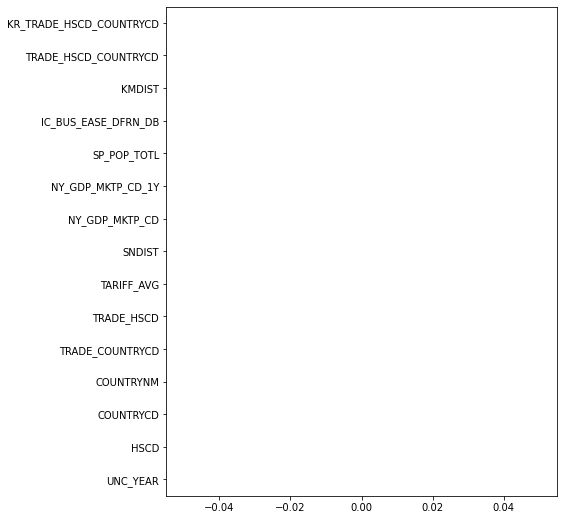

In [ ]:
df.isnull().mean().plot.barh(figsize=(7,9))

In [ ]:
columns = ["HSCD","COUNTRYCD","TRADE_COUNTRYCD","TRADE_HSCD","TARIFF_AVG","SNDIST","NY_GDP_MKTP_CD","NY_GDP_MKTP_CD_1Y","SP_POP_TOTL","IC_BUS_EASE_DFRN_DB","KMDIST","TRADE_HSCD_COUNTRYCD","KR_TRADE_HSCD_COUNTRYCD"]
df = df[columns].copy()

In [ ]:
df.shape

(21168, 13)

In [ ]:
df["percent"] = df["KR_TRADE_HSCD_COUNTRYCD"] / df["TRADE_HSCD_COUNTRYCD"] * 100
df["percent"]

0       0.22413
1       1.20680
2       0.07410
3       0.02459
4       0.39212
          ...  
21183   1.35768
21184   0.42850
21185   7.17273
21187   1.73932
21188   2.78358
Name: percent, Length: 21168, dtype: float64

In [ ]:
df = df.drop('KR_TRADE_HSCD_COUNTRYCD', axis=1).copy()
df = df.drop('TRADE_HSCD_COUNTRYCD', axis=1).copy()

In [ ]:

df = df.drop('SNDIST', axis=1).copy()
df = df.drop('KMDIST', axis=1).copy()

In [ ]:
df.shape

(21168, 10)

In [ ]:
print(df.shape)
tr = int(df.shape[0]*6/10)
te = int((df.shape[0] - tr)/2)
va = df.shape[0] - tr - te
print(tr,te, va)

(21168, 10)
12700 4234 4234


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
batch_size = 16
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 3

units = 16
output_size = 3358  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim), activation='relu')
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [ ]:
df_perc = df["percent"].copy()
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/x.std(), axis=0)
df_back = df.copy()
df = mean_norm(df)
df["percent"] = df_perc
df.head()

,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,IC_BUS_EASE_DFRN_DB,percent
0,-2.71574,-1.72386,-0.63906,0.11011,3.08139,-0.42954,-0.42626,-0.28530,-2.33105,0.22413
1,-2.71574,-1.62947,-0.24606,0.11011,-0.37695,-0.09217,-0.10439,-0.34429,0.89907,1.20680
2,-2.71574,-1.61373,-0.37958,0.11011,-0.37695,-0.35762,-0.35397,-0.39983,0.76962,0.07410
3,-2.71574,-1.55080,0.13742,0.11011,-0.37695,-0.33275,-0.32937,-0.39077,0.15915,0.02459
4,-2.71574,-1.47214,-0.41347,0.11011,1.69805,0.12139,0.07570,0.29960,-1.45306,0.39212


In [ ]:
import torch

x_train = np.array(df.iloc[:tr+te,:-1].values)
y_train = np.array(df.iloc[:tr+te,-1].values)
x_test = np.array(df.iloc[tr+te:,:-1].values)
y_test = np.array(df.iloc[tr+te:,-1].values)

max(y_train)

3357.3670103606646

In [ ]:
## Linear Test Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
torch.manual_seed(1)

In [ ]:
x_train.shape

(16934, 9)

In [ ]:
x_train[0]

array([-2.71573567, -1.72386485, -0.63906278,  0.1101143 ,  3.08139384,
       -0.42954444, -0.42626326, -0.28529889, -2.33105123])

In [ ]:
model = nn.Linear(x_train.shape[1], 1)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)
epochs = 20000

In [ ]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

y_train = y_train.reshape(-1,1)

for epoch in range(epochs+1):
    pred = model(x_train)
    
    cost = F.mse_loss(pred, y_train)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print('Epoch : {}/{}, Cost = {}'.format(epoch, epochs, cost.item()))
        

Epoch : 0/20000, Cost = 2088.326904296875
Epoch : 100/20000, Cost = 2088.159423828125
Epoch : 200/20000, Cost = 2087.991943359375
Epoch : 300/20000, Cost = 2087.825927734375
Epoch : 400/20000, Cost = 2087.66064453125
Epoch : 500/20000, Cost = 2087.49609375
Epoch : 600/20000, Cost = 2087.33203125
Epoch : 700/20000, Cost = 2087.1689453125
Epoch : 800/20000, Cost = 2087.006591796875
Epoch : 900/20000, Cost = 2086.844970703125
Epoch : 1000/20000, Cost = 2086.68408203125
Epoch : 1100/20000, Cost = 2086.52392578125
Epoch : 1200/20000, Cost = 2086.3642578125
Epoch : 1300/20000, Cost = 2086.2060546875
Epoch : 1400/20000, Cost = 2086.0478515625
Epoch : 1500/20000, Cost = 2085.890625
Epoch : 1600/20000, Cost = 2085.734130859375
Epoch : 1700/20000, Cost = 2085.57861328125
Epoch : 1800/20000, Cost = 2085.42333984375
Epoch : 1900/20000, Cost = 2085.269287109375
Epoch : 2000/20000, Cost = 2085.115966796875
Epoch : 2100/20000, Cost = 2084.962890625
Epoch : 2200/20000, Cost = 2084.810791015625
Epoch :

In [ ]:
x_train.shape

torch.Size([16934, 9])

In [ ]:
y_train.shape

torch.Size([16934, 1])

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# W = torch.zeros((9,1), requires_grad=True)
# b = torch.zeros(1, requires_grad=True)
# optimizer = optim.SGD([W,b], lr=1e-3)

# nb_epochs = 20
# for epoch in range(nb_epochs + 1):

#     # H(x) 계산
#     # 편향 b는 브로드 캐스팅되어 각 샘플에 더해집니다.
#     hypothesis = x_train.matmul(W) + b

#     # cost 계산
#     cost = torch.mean((hypothesis - y_train) ** 2)

#     # cost로 H(x) 개선
#     optimizer.zero_grad()
#     cost.backward()
#     optimizer.step()

#     print('Epoch {:4d}/{} hypothesis: {} Cost: {:.6f}'.format(
#         epoch, nb_epochs, hypothesis.squeeze().detach(), cost.item()
#     ))

In [ ]:
new_var = torch.FloatTensor(df.iloc[2][:-1])
new_var = new_var.reshape(1,-1)
new_var

tensor([[-2.7157, -1.6137, -0.3796,  0.1101, -0.3770, -0.3576, -0.3540, -0.3998,
          0.7696]])

In [ ]:
pred_y = model(new_var)

In [ ]:
pred_y

tensor([[1.1609]], grad_fn=<AddmmBackward>)

In [ ]:
df.iloc[2][:-1]

HSCD                  -2.71574
COUNTRYCD             -1.61373
TRADE_COUNTRYCD       -0.37958
TRADE_HSCD             0.11011
TARIFF_AVG            -0.37695
NY_GDP_MKTP_CD        -0.35762
NY_GDP_MKTP_CD_1Y     -0.35397
SP_POP_TOTL           -0.39983
IC_BUS_EASE_DFRN_DB    0.76962
Name: 2, dtype: float64

In [ ]:
torch.FloatTensor(x_test[0]).reshape(1,-1)

tensor([[ 0.5468, -1.1732, -0.5977, -0.0511, -0.3770, -0.3984, -0.3985, -0.3658,
          0.0808]])

In [ ]:
import math

err_sum = 0.0
for i in range(x_test.shape[0]):
    new_var = torch.FloatTensor(x_test[i]).reshape(1,-1)
    pred_y = model(new_var)
    err_val = y_test[i] - pred_y
    err_sum += np.sqrt(math.pow(err_val, 2))


In [ ]:
err_sum / x_test.shape[0]

4.08404971490604

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2018,190590,12,Algeria,42196119729.00000,22234640370.00000,27.00000,3735.04739,175406000000.00000,170163000000.00000,42228429.00000,100.69143,46.22686,9954.00977,6788998.00000,nan
1,2018,190590,36,Australia,240423000000.00000,22234640370.00000,1.20000,11947.51136,1432880000000.00000,1329190000000.00000,24982688.00000,1.03584,80.76007,8329.65234,482560567.00000,nan
2,2018,190590,40,Austria,186965000000.00000,22234640370.00000,2.80000,4005.02003,455095000000.00000,417238000000.00000,8840521.00000,nan,78.70694,8289.02930,499925873.00000,nan
3,2018,190590,56,Belgium,461445000000.00000,22234640370.00000,2.80000,4501.78283,543734000000.00000,502698000000.00000,11427054.00000,nan,72.18146,8722.11426,769101370.00000,nan
4,2018,190590,76,Brazil,185290000000.00000,22234640370.00000,17.10000,10015.76907,1885480000000.00000,2062830000000.00000,209469333.00000,2.15609,55.80145,18364.50586,40817292.00000,nan


In [ ]:
columns = ["HSCD","COUNTRYCD","TRADE_COUNTRYCD","TRADE_HSCD","TARIFF_AVG","SNDIST","NY_GDP_MKTP_CD","NY_GDP_MKTP_CD_1Y","SP_POP_TOTL","IC_BUS_EASE_DFRN_DB","KMDIST","TRADE_HSCD_COUNTRYCD","KR_TRADE_HSCD_COUNTRYCD"]
test_df = test_df[columns].copy()

test_df['SNDIST'] = test_df['SNDIST'].fillna(test_df['SNDIST'].mean())
test_df['TARIFF_AVG'] = test_df['TARIFF_AVG'].fillna(test_df['TARIFF_AVG'].mean())


test_df = test_df.drop('SNDIST', axis=1).copy()
test_df = test_df.drop('KMDIST', axis=1).copy()


In [ ]:
test_df.head()

,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,IC_BUS_EASE_DFRN_DB,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,190590,12,42196119729.00000,22234640370.00000,27.00000,175406000000.00000,170163000000.00000,42228429.00000,46.22686,6788998.00000,nan
1,190590,36,240423000000.00000,22234640370.00000,1.20000,1432880000000.00000,1329190000000.00000,24982688.00000,80.76007,482560567.00000,nan
2,190590,40,186965000000.00000,22234640370.00000,2.80000,455095000000.00000,417238000000.00000,8840521.00000,78.70694,499925873.00000,nan
3,190590,56,461445000000.00000,22234640370.00000,2.80000,543734000000.00000,502698000000.00000,11427054.00000,72.18146,769101370.00000,nan
4,190590,76,185290000000.00000,22234640370.00000,17.10000,1885480000000.00000,2062830000000.00000,209469333.00000,55.80145,40817292.00000,nan


In [ ]:
test_df = mean_norm(test_df)
x_test = np.array(test_df.iloc[:,:-2].values)
x_test[0]

array([-2.71217613, -1.72467426, -0.65658563,  0.11474505,  2.72387212,
       -0.42743595, -0.42940035, -0.28357208, -2.43669591])

In [ ]:
result = pd.read_csv('test.csv')
pd.options.display.float_format = '{:.5f}'.format
res = []
for i in range(x_test.shape[0]):
    new_var = torch.FloatTensor(x_test[i]).reshape(1,-1)
    pred_y = model(new_var)
    result["KR_TRADE_HSCD_COUNTRYCD"][i] = (result["TRADE_HSCD_COUNTRYCD"][i] * (float(pred_y)/100))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
result.to_csv("filename.csv", mode='w')